In [135]:
import h5py
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.fft import ifftn

import os, sys
from os import listdir
from os.path import isfile, join

sys.path.append('/home/vanveen/ConvDecoder/')
from utils.transform import fftshift, ifftshift, ifft_2d

### note to self

use `.transpose()` for numpy arrays and `.permute()` for pytorch arrays

In [133]:
def plot_slices(vol):
    ''' given 3D array vol, plot slices of first dimn by first four cols '''
    
    num_cols = 4
    num_rows = len(vol) // num_cols
    
    fig = plt.figure(figsize=(10*num_cols,10*num_rows))

    for idx, img in enumerate(vol):
        ax = fig.add_subplot(num_rows, num_cols, idx+1)
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        plt.tight_layout()

### load data

In [132]:
path = '/bmrNAS/people/arjun/data/qdess_knee_2020/files_recon_calib-16/'
files = [f for f in listdir(path) if isfile(join(path, f))]
files.sort()

fn = files[0]
f = h5py.File(path + fn, 'r')
ksp = torch.from_numpy(f['kspace'][()])
targ = torch.from_numpy(f['target'][()])

### plot target in sagittal (left/right), axial (top/bottom), or coronal (front/back)

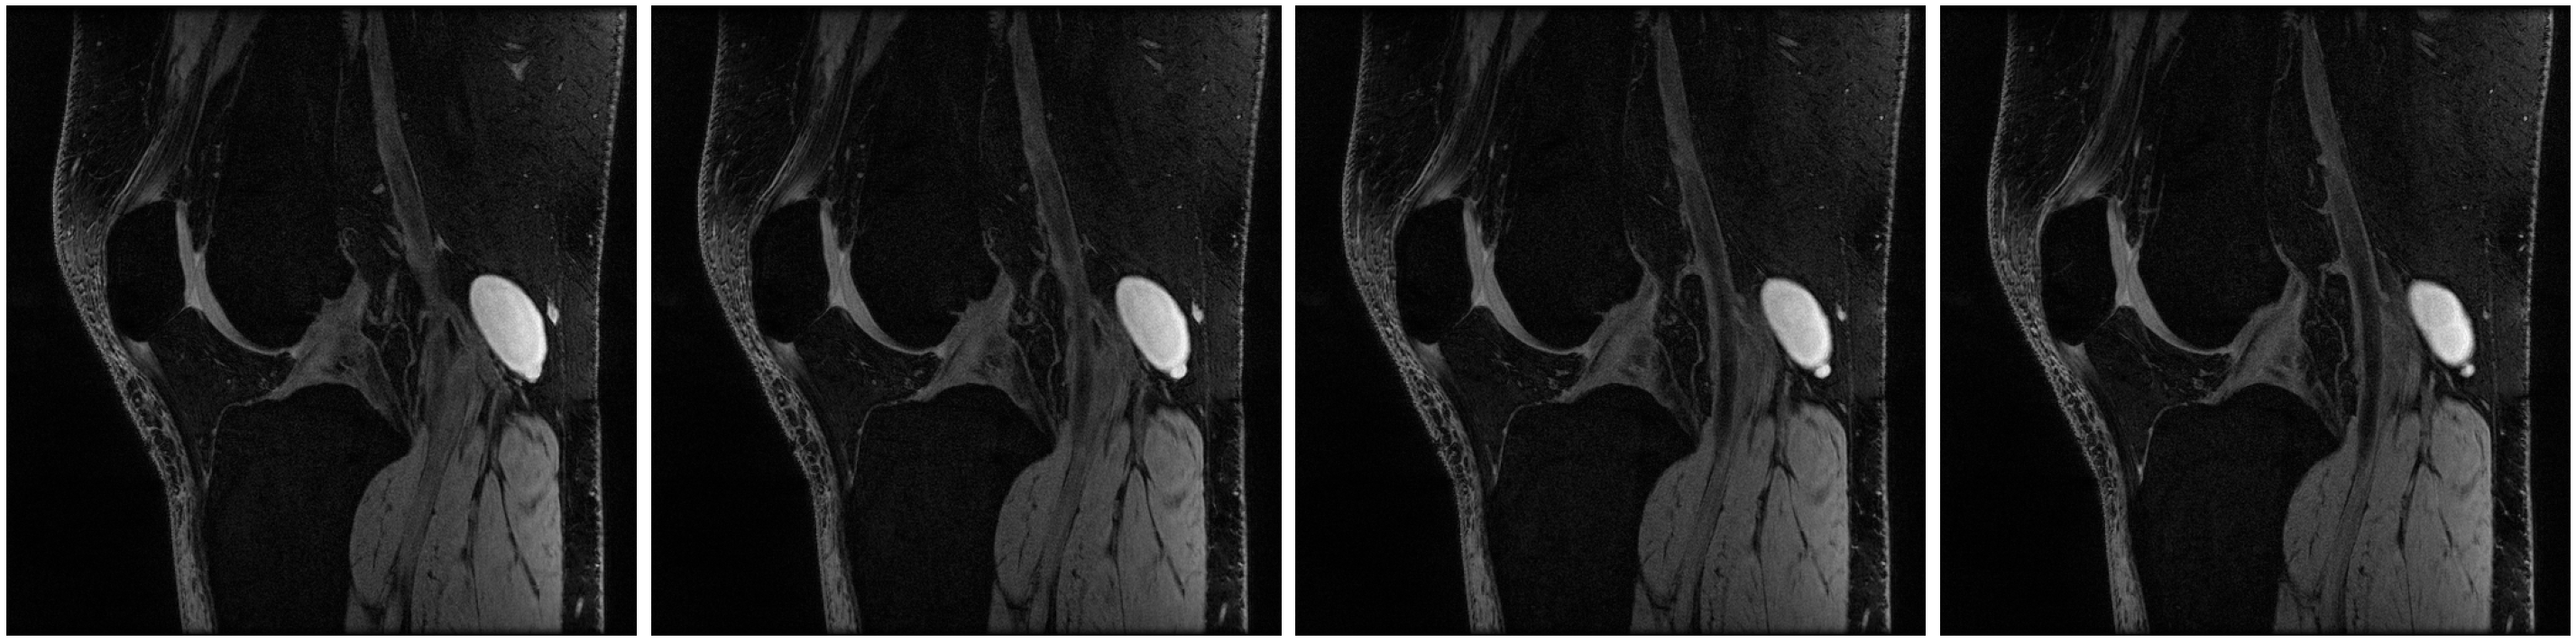

In [128]:
targ_ = targ[:,:,:,0,0] # get echo1

idx_sag = targ_.shape[2] // 2 # idx if splitting sagitally, i.e. on kz
targ_sag = abs(targ_[:,:,idx_sag-2:idx_sag+2].permute(2,0,1))

idx_ax = targ_.shape[0] // 2 # idx if splitting axially, i.e. on kx
targ_ax = abs(targ_[idx_ax-2:idx_ax+2,:,:])

idx_cor = targ_.shape[0] // 2 # idx if splitting coronally, i.e. on ky
targ_cor = abs(targ_[:,idx_cor-2:idx_cor+2,:].permute(1,0,2))

plot_slices(targ_sag)

### recon and plot fully-sampled k-space

In [134]:
ksp_vol = ksp[:, :, :, 0, :].permute(3,0,1,2)
ksp_vol.shape

torch.Size([16, 512, 512, 160])

In [130]:
 # select one of the echos
ksp_vol = ksp[:, :, :, 0, :].permute(3,0,1,2)

# do ifft
img_vol = ifft_2d(ksp_vol)

# get magnitudes
img_vol = abs(img_vol)

# combine coils via rss. TODO: implement sense
img_vol = torch.sqrt(torch.sum(torch.square(img_vol), axis=0))

In [136]:
img_vol.dtype

torch.float32

to recon correctly, do 2d ifft in ky, kz. will be undersampling in ky, kz

- sagittal: slice in kz, get blurry recon w 1d ifft in ky
- axial: slice in kx, get blurry recon w 3d ifft in kx, ky, kz
- coronal: slice in ky, get blurry recon w 1d ifft in kz

### plotting sagittal

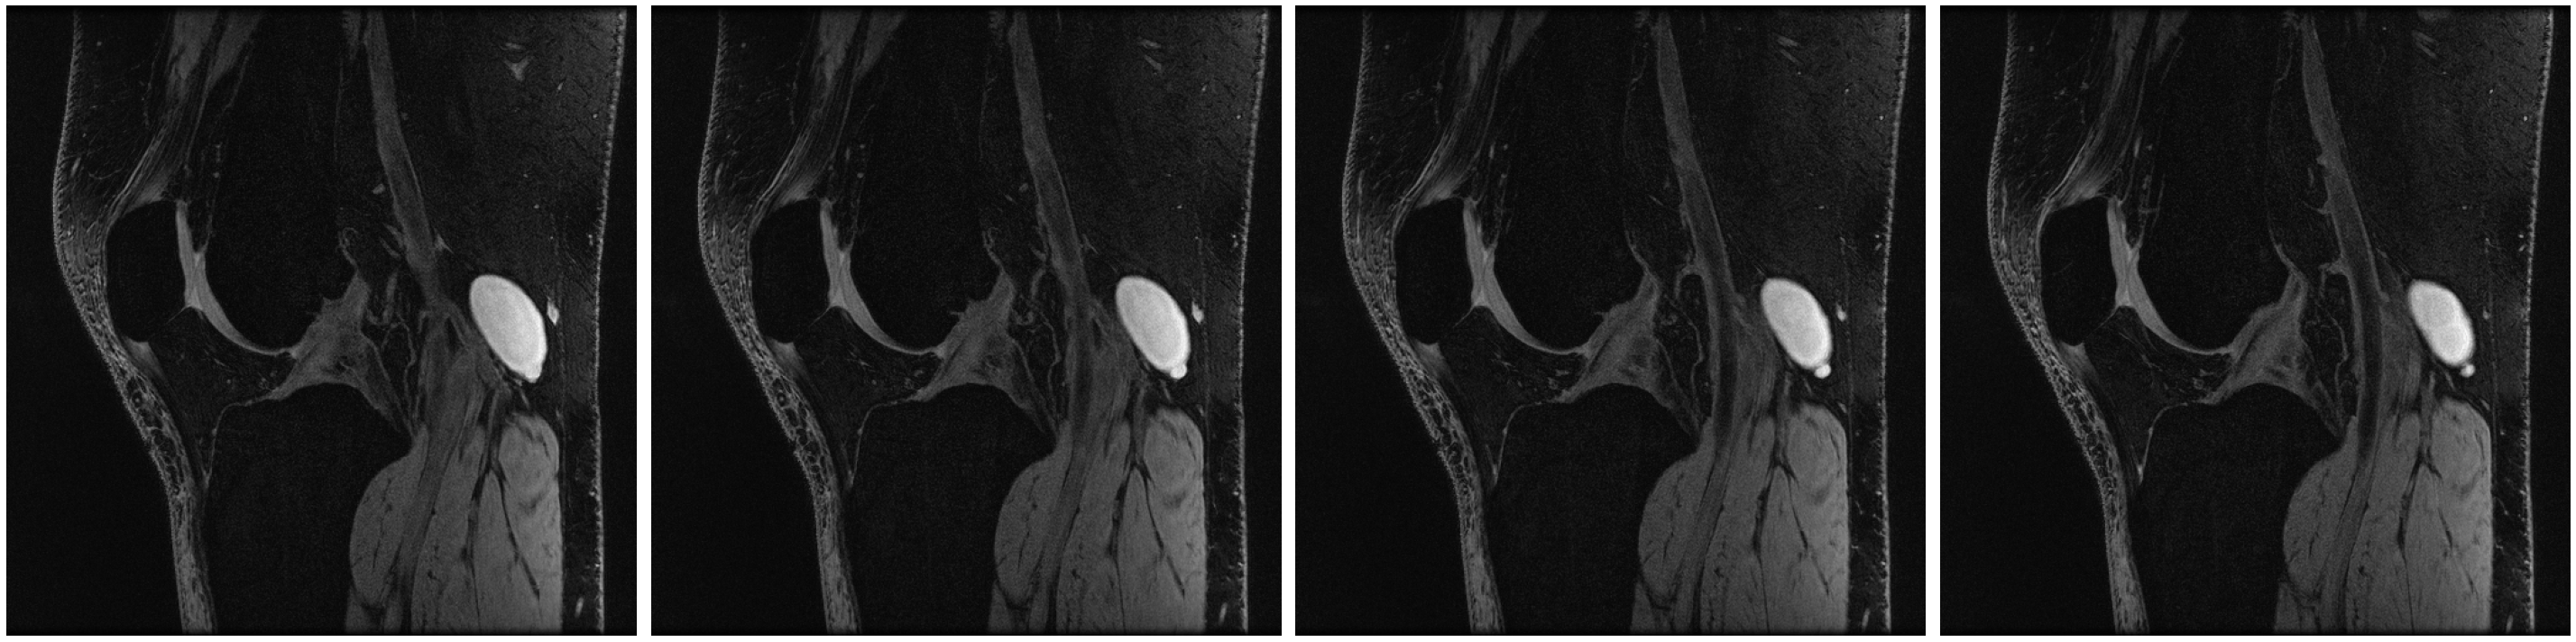

In [131]:
plot_slices(img_vol[:,:,idx_sag-2:idx_sag+2].permute(2,0,1))

### plotting axial

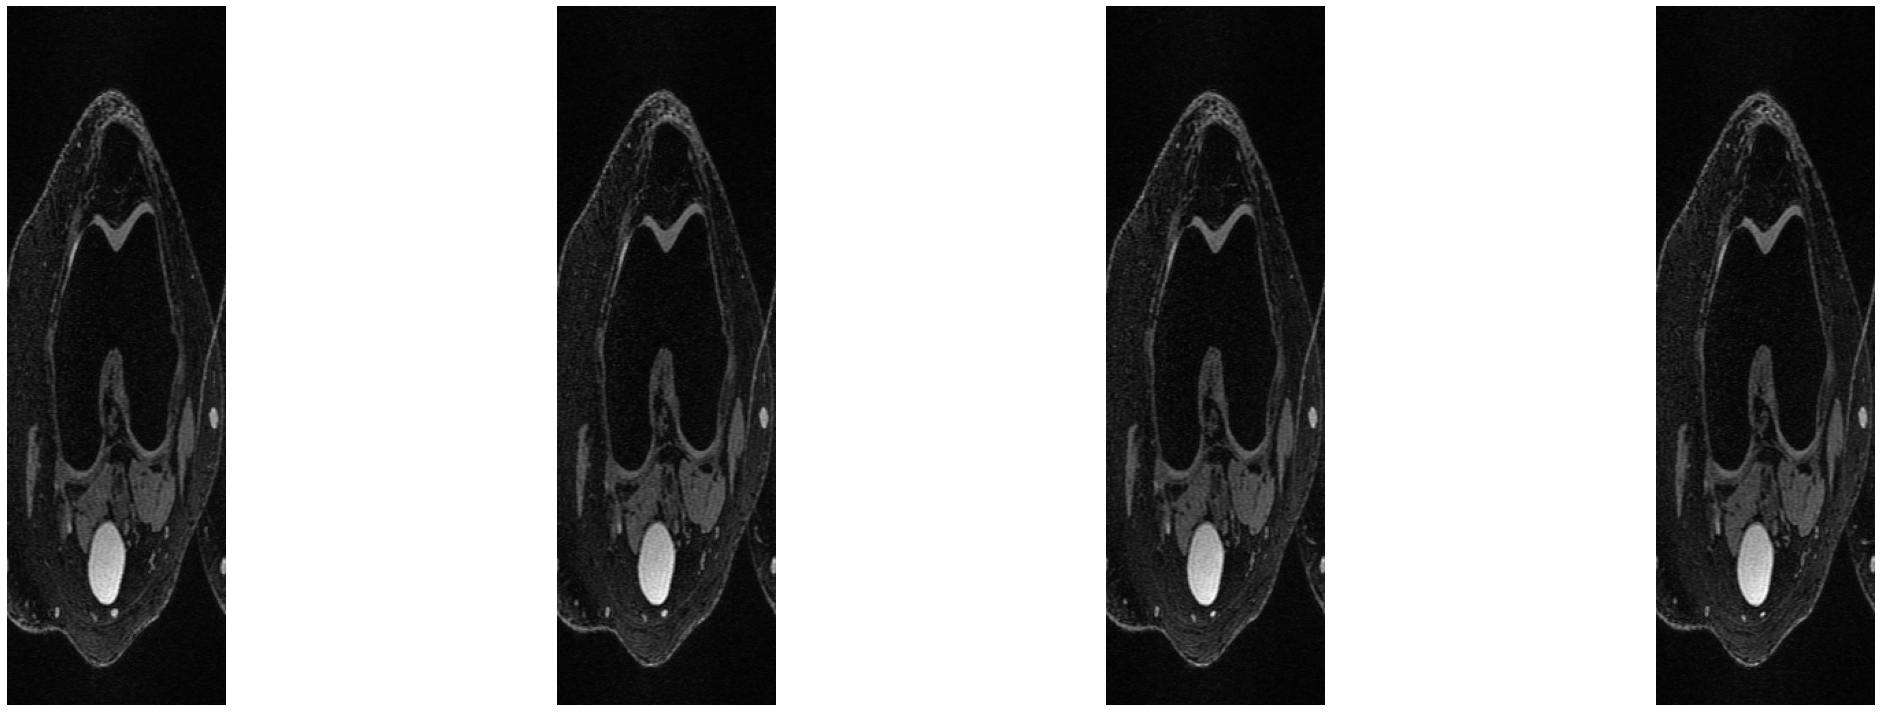

In [120]:
img_ax = img_vol[idx_ax-2:idx_ax+2,:,:]
plot_slices(img_ax)

### plotting coronal

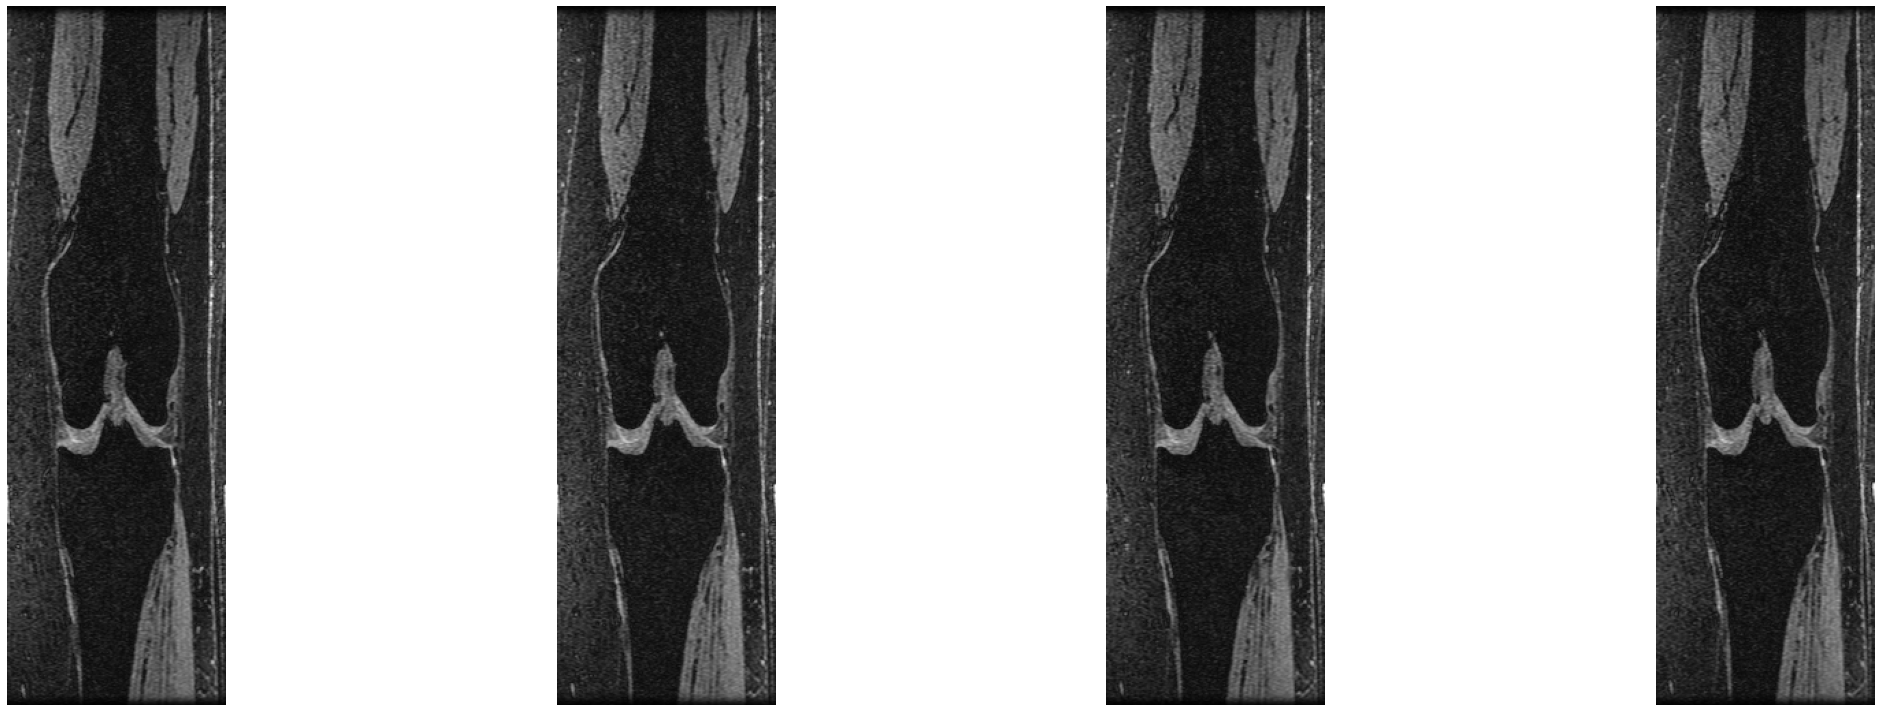

In [121]:
img_cor = img_vol[:,idx_cor-2:idx_cor+2,:].permute(1,0,2)
plot_slices(img_cor)